# **De Flujos de Red a Alertas SIEM: *Detección de Intrusiones con Random Forest en CICIDS2017***

##Introducción

Uno de los mayores desafíos en los entornos de ciberseguridad actuales es la capacidad de los analistas para sintetizar y contextualizar rápidamente grandes volúmenes de datos generados a lo largo de la superficie de ataque. El tráfico de red, los logs y las alertas se producen de forma continua y a un ritmo muy superior al que los equipos pueden analizar manualmente, lo que incrementa el riesgo de detecciones tardías o ineficientes.

En este contexto, el uso de técnicas de machine learning permite analizar de manera eficiente grandes volúmenes de tráfico histórico y dinámico, facilitando la identificación de patrones anómalos y comportamientos maliciosos. Estos enfoques hacen posible el análisis de datos procedentes de múltiples fuentes en entornos casi en tiempo real, reforzando la capacidad de respuesta de los equipos de seguridad.


Los ciclos de entrenamiento regulares permiten que los modelos aprendan de forma continua a partir de una serie de muestras en evolución, que incluye detecciones etiquetadas por analistas o alertas revisadas manualmente. Esto ayuda a prevenir falsos positivos recurrentes y permite a los modelos aprender y reforzar un ground truth generado por expertos.



##**Dataset: CICIDS2017**

Este proyecto explora la aplicación de un modelo binario de detección de intrusiones basado en Random Forest utilizando el dataset CICIDS2017, un benchmark público ampliamente utilizado y proporcionado por el Canadian Institute for Cybersecurity. El conjunto de datos representa tráfico realista de una red corporativa e incluye tanto conexiones benignas como múltiples categorías de ataques, entre las que se encuentran DoS, DDoS, PortScan, Web Attacks, Infiltration y actividad Botnet.

Se lleva a cabo un análisis exploratorio inicial de los datos (EDA) con el objetivo de examinar la distribución de clases, las características de las variables, las correlaciones existentes y posibles problemas de calidad de los datos. A partir de este análisis, se define un pipeline de preprocesamiento reproducible que garantiza la coherencia entre las fases de entrenamiento e inferencia del modelo.

El objetivo principal de este notebook es construir y evaluar un clasificador binario capaz de distinguir tráfico malicioso (Attack) de tráfico benigno (Benign), con un enfoque claro en su aplicabilidad práctica dentro de sistemas de detección de intrusiones basados en SIEM. La evaluación del modelo no se limita a la precisión global, sino que pone especial énfasis en el rendimiento de detección y en el comportamiento frente a falsos positivos, factores críticos en entornos de seguridad operativos.

In [ ]:
import numpy as np
import pandas as pd

In [ ]:
from google.colab import drive
drive.mount("/content/drive/")
df = pd.read_csv("/content/drive/MyDrive/Inteligenia Artificial/Curso Especialista IA/Caso Practico/files/cicids2017_set.csv")
#df = pd.read_csv("/files/cicids2017_set.csv")

Mounted at /content/drive/


In [ ]:
df.head()

,Flow ID,Src IP,Src Port,Dst IP,Dst Port,Protocol,Timestamp,Flow Duration,Total Fwd Packet,Total Bwd packets,...,Active Max,Active Min,Idle Mean,Idle Std,Idle Max,Idle Min,ICMP Code,ICMP Type,Total TCP Flow Time,Is_Benign
0,192.168.10.12-192.168.10.3-4781-53-17,192.168.10.12,4781,192.168.10.3,53,17,2017-07-03 12:49:17.299527,114491,2,2,...,0,0,0.0,0.0,0,0,-1,-1,0,1
1,172.16.0.1-192.168.10.50-36010-34573-6,172.16.0.1,36010,192.168.10.50,34573,6,2017-07-07 17:55:51.144265,26,1,1,...,0,0,0.0,0.0,0,0,-1,-1,26,0
2,192.168.10.15-192.168.10.3-49641-53-17,192.168.10.15,49641,192.168.10.3,53,17,2017-07-05 19:40:29.299074,221,2,2,...,0,0,0.0,0.0,0,0,-1,-1,0,1
3,192.168.10.17-69.172.216.56-35294-443-6,192.168.10.17,35294,69.172.216.56,443,6,2017-07-04 18:45:13.934935,206474,25,32,...,0,0,0.0,0.0,0,0,-1,-1,206474,1
4,192.168.10.17-192.168.10.3-54825-53-17,192.168.10.17,54825,192.168.10.3,53,17,2017-07-06 18:20:30.765595,92136,2,2,...,0,0,0.0,0.0,0,0,-1,-1,0,1


In [ ]:
df.select_dtypes(include=['object']).shape[1]

4

In [ ]:
df_model = df.select_dtypes(exclude=['object']).copy()
cols_removed = df.select_dtypes(include=['object']).columns.tolist()
print(cols_removed)

['Flow ID', 'Src IP', 'Dst IP', 'Timestamp']


In [ ]:
df_model.select_dtypes(include=['object']).shape[1]

0

In [ ]:
df_model = df_model.drop(columns=['Src Port', 'Dst Port', 'Protocol'])

##**La correlación entre variables**

El análisis de correlación entre variables se utiliza para identificar información redundante, reducir la dimensionalidad del conjunto de características y mejorar la estabilidad del modelo y la eficiencia en la inferencia. La reducción de variables altamente correlacionadas es especialmente relevante en despliegues orientados a SIEM, donde la baja latencia y la eficiencia en el uso de memoria son aspectos críticos.

In [ ]:
corr_matrix = df_model.corr(method='pearson')
print(corr_matrix)

                            Flow Duration  Total Fwd Packet  \
Flow Duration                    1.000000          0.025814   
Total Fwd Packet                 0.025814          1.000000   
Total Bwd packets                0.024768          0.998904   
Total Length of Fwd Packet       0.167306          0.053317   
Total Length of Bwd Packet       0.020138          0.995590   
...                                   ...               ...   
Idle Min                         0.612616          0.003359   
ICMP Code                       -0.000570         -0.000088   
ICMP Type                        0.000505         -0.000108   
Total TCP Flow Time              0.095391          0.004033   
Is_Benign                        0.165228          0.004755   

                            Total Bwd packets  Total Length of Fwd Packet  \
Flow Duration                        0.024768                    0.167306   
Total Fwd Packet                     0.998904                    0.053317   
Total Bwd pa

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

# Dark theme
plt.style.use("dark_background")

# Custom palette
cyber_palette = ["#00FFFF", "#00FF7F", "#1E90FF", "#7B68EE", "#FF1493", "#9400D3", "#00CED1", "#32CD32", "#FFD700", "#FF4500"]

# Ignore warnings
import warnings
warnings.filterwarnings("ignore", message="The palette list has more values")
warnings.filterwarnings("ignore", category=FutureWarning)
warnings.filterwarnings("ignore", category=UserWarning)

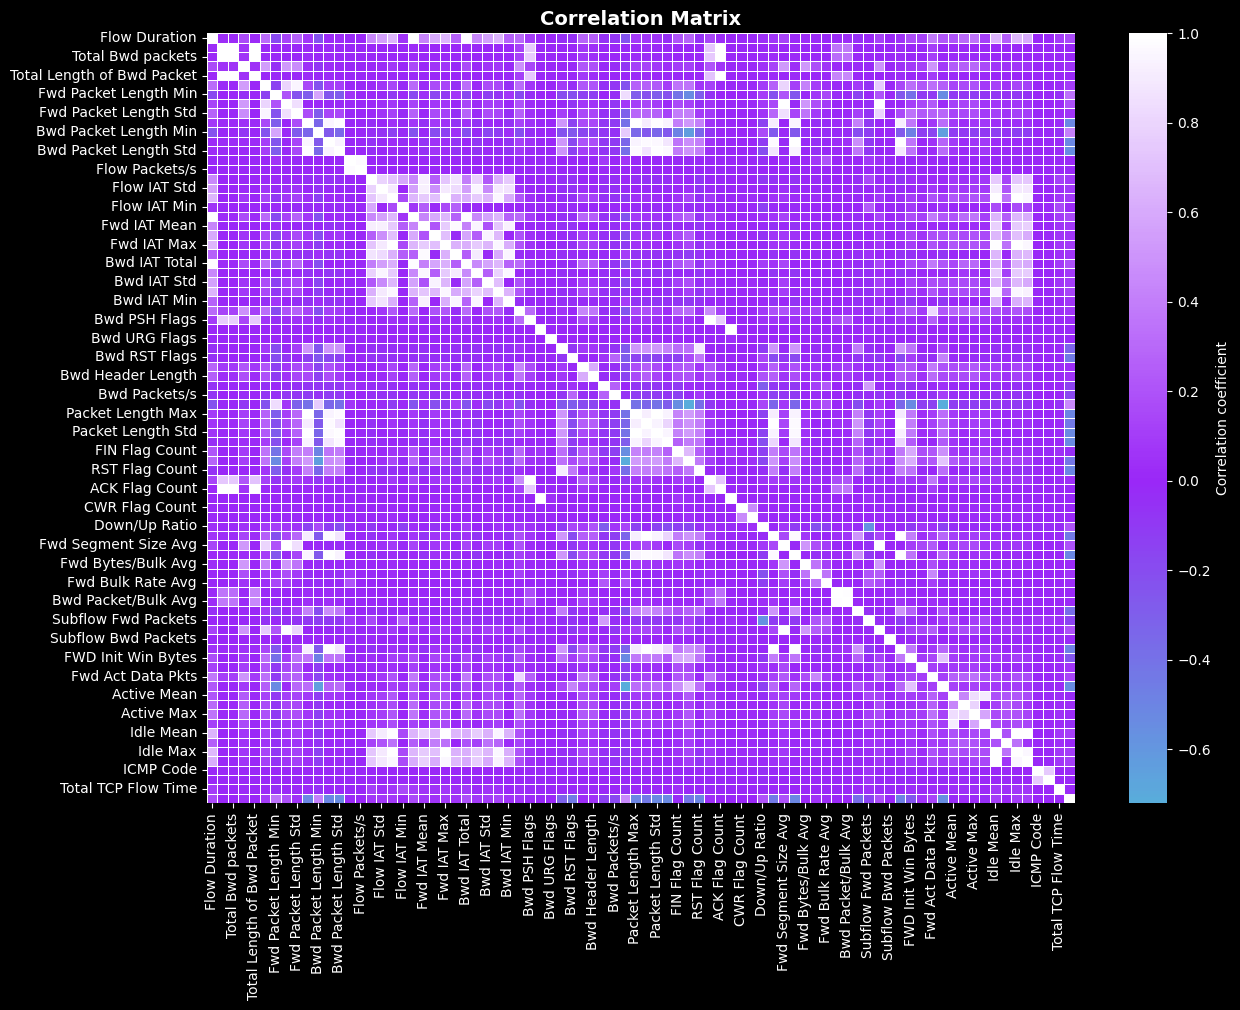

In [ ]:
from matplotlib.colors import LinearSegmentedColormap
cmap_custom = LinearSegmentedColormap.from_list("my_div_cmap", ["#40E0D0", "#9A27F7", "#FFFFFF"])

plt.figure(figsize=(14, 10))
sns.heatmap(corr_matrix, cmap=cmap_custom, center=0, annot=False, linewidths=0.5, cbar_kws={'label': 'Correlation coefficient'})
plt.title('Correlation Matrix', fontsize=14, weight='bold')

plt.show()

In [ ]:
upper = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(bool))

to_drop = [
    column for column in upper.columns
    if any(upper[column].abs() > 0.9)
]

df_model = df_model.drop(columns=to_drop)

In [ ]:
df_model.head()
# df_model.to_csv('cicids2017_cleaned.csv', index=False')

,Flow Duration,Total Fwd Packet,Total Length of Fwd Packet,Fwd Packet Length Max,Fwd Packet Length Min,Fwd Packet Length Mean,Bwd Packet Length Max,Bwd Packet Length Min,Flow Bytes/s,Flow IAT Mean,...,Fwd Act Data Pkts,Fwd Seg Size Min,Active Mean,Active Std,Active Max,Idle Std,ICMP Code,ICMP Type,Total TCP Flow Time,Is_Benign
0,114491,2,64,32,32,32.00,125,125,2.742574e+03,38163.666667,...,1,8,0.0,0.0,0,0.0,-1,-1,0,1
1,26,1,0,0,0,0.00,0,0,0.000000e+00,26.000000,...,0,40,0.0,0.0,0,0.0,-1,-1,26,0
2,221,2,66,33,33,33.00,193,193,2.045249e+06,73.666667,...,1,8,0.0,0.0,0,0.0,-1,-1,0,1
3,206474,25,1758,1375,0,70.32,4344,0,2.898379e+05,3687.035714,...,3,32,0.0,0.0,0,0.0,-1,-1,206474,1
4,92136,2,60,30,30,30.00,81,81,2.409482e+03,30712.000000,...,1,8,0.0,0.0,0,0.0,-1,-1,0,1


## **Entrenamiento del modelo**
El problema se formula como una tarea de clasificación binaria, en la que todos los tipos de ataque se agrupan en una única clase “Is_Benign” y se contrastan frente al tráfico malicioso.

In [ ]:
x = df_model.drop('Is_Benign', axis=1)
y = df_model['Is_Benign']

print(x.shape)
print(y.shape)
x.describe()

(440995, 49)
(440995,)


,Flow Duration,Total Fwd Packet,Total Length of Fwd Packet,Fwd Packet Length Max,Fwd Packet Length Min,Fwd Packet Length Mean,Bwd Packet Length Max,Bwd Packet Length Min,Flow Bytes/s,Flow IAT Mean,...,Bwd Init Win Bytes,Fwd Act Data Pkts,Fwd Seg Size Min,Active Mean,Active Std,Active Max,Idle Std,ICMP Code,ICMP Type,Total TCP Flow Time
count,4.409950e+05,440995.000000,440995.000000,440995.000000,440995.000000,440995.000000,440995.000000,440995.000000,4.409950e+05,4.409950e+05,...,440995.000000,440995.0000,440995.000000,4.409950e+05,4.409950e+05,4.409950e+05,4.409950e+05,440995.000000,440995.000000,4.409950e+05
mean,1.239310e+07,12.439393,559.225259,209.833735,21.305561,49.886407,1228.628576,53.663087,4.914834e+05,9.208819e+05,...,757.373707,2.2012,17.039341,1.268632e+05,5.945168e+04,2.268973e+05,2.921016e+05,-0.998882,-0.998624,3.195424e+07
std,3.097840e+07,884.689483,4118.909329,495.556356,35.559110,92.648869,2249.460294,74.920161,1.557787e+07,4.079216e+06,...,4436.920014,5.8360,10.009592,7.745694e+05,4.764880e+05,1.213818e+06,2.657926e+06,0.084576,0.091773,3.947278e+08
min,0.000000e+00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000e+00,0.000000e+00,...,0.000000,0.0000,0.000000,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,-1.000000,-1.000000,0.000000e+00
25%,2.460000e+02,2.000000,48.000000,32.000000,0.000000,28.285714,60.000000,0.000000,1.077481e+02,8.400000e+01,...,0.000000,0.0000,8.000000,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,-1.000000,-1.000000,0.000000e+00
50%,6.175700e+04,2.000000,80.000000,45.000000,0.000000,40.678571,128.000000,0.000000,3.877370e+03,1.876615e+04,...,0.000000,1.0000,20.000000,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,-1.000000,-1.000000,2.500000e+01
75%,4.328900e+06,8.000000,357.000000,309.000000,41.000000,51.625000,1448.000000,100.000000,6.235327e+04,3.053523e+05,...,229.000000,2.0000,24.000000,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,-1.000000,-1.000000,3.076652e+06
max,1.200000e+08,219759.000000,722939.000000,24820.000000,1472.000000,4968.757576,17376.000000,1983.000000,1.000000e+10,6.416160e+07,...,65535.000000,768.0000,44.000000,1.024784e+08,7.415440e+07,1.049884e+08,7.691483e+07,10.000000,11.000000,2.910406e+10


In [ ]:
from sklearn.model_selection import train_test_split

x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.3, random_state=42, stratify=y)

x_train.shape

(308696, 49)

## **Random Forest classifier**

Se selecciona un clasificador Random Forest debido a su robustez frente a datos ruidosos y de alta dimensionalidad, su buen rendimiento con un ajuste mínimo de hiperparámetros y su capacidad para proporcionar estimaciones de la importancia de las variables. Estas propiedades lo hacen especialmente adecuado para tareas de detección de intrusiones en datasets de tráfico de red a gran escala y heterogéneos como CICIDS2017.


In [ ]:
from sklearn.ensemble import RandomForestClassifier

rf = RandomForestClassifier(n_estimators=100, random_state=42, verbose=1)
rf.fit(x_train, y_train)

[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:   47.4s
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:  1.6min finished


RandomForestClassifier(random_state=42, verbose=1)

In [ ]:
rf.get_params()

{'bootstrap': True,
 'ccp_alpha': 0.0,
 'class_weight': None,
 'criterion': 'gini',
 'max_depth': None,
 'max_features': 'sqrt',
 'max_leaf_nodes': None,
 'max_samples': None,
 'min_impurity_decrease': 0.0,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'min_weight_fraction_leaf': 0.0,
 'monotonic_cst': None,
 'n_estimators': 100,
 'n_jobs': None,
 'oob_score': False,
 'random_state': 42,
 'verbose': 1,
 'warm_start': False}

## **El rendimiento del modelo**

El rendimiento del modelo se evalúa utilizando métricas estándar de clasificación binaria, incluyendo accuracy, precision, recall y F1-score. En el contexto de la detección de intrusiones, el recall es especialmente crítico, ya que los falsos negativos corresponden a ataques no detectados, mientras que la precision refleja el coste operativo asociado a las alertas falsas.

In [ ]:
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report

y_pred = rf.predict(x_test)

print('Accuracy:', accuracy_score(y_test, y_pred))
print('\nConfusion Matrix:\n')
print(confusion_matrix(y_test, y_pred))
print('\nClassification Report:\n')
print(classification_report(y_test,y_pred))

[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    0.6s


Accuracy: 0.9995540404689378

Confusion Matrix:

[[32562    35]
 [   24 99678]]

Classification Report:

              precision    recall  f1-score   support

           0       1.00      1.00      1.00     32597
           1       1.00      1.00      1.00     99702

    accuracy                           1.00    132299
   macro avg       1.00      1.00      1.00    132299
weighted avg       1.00      1.00      1.00    132299



[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    1.3s finished


##**Feature Importance**

El análisis de feature importance proporciona información sobre qué atributos del tráfico de red tienen mayor influencia en las decisiones del modelo. En los modelos Random Forest, estas importancias reflejan cuánto contribuye cada variable a mejorar la pureza de los nodos a lo largo del conjunto de árboles. Analizar la importancia de las variables permite identificar las características de tráfico más relevantes para distinguir entre conexiones benignas y actividad maliciosa.

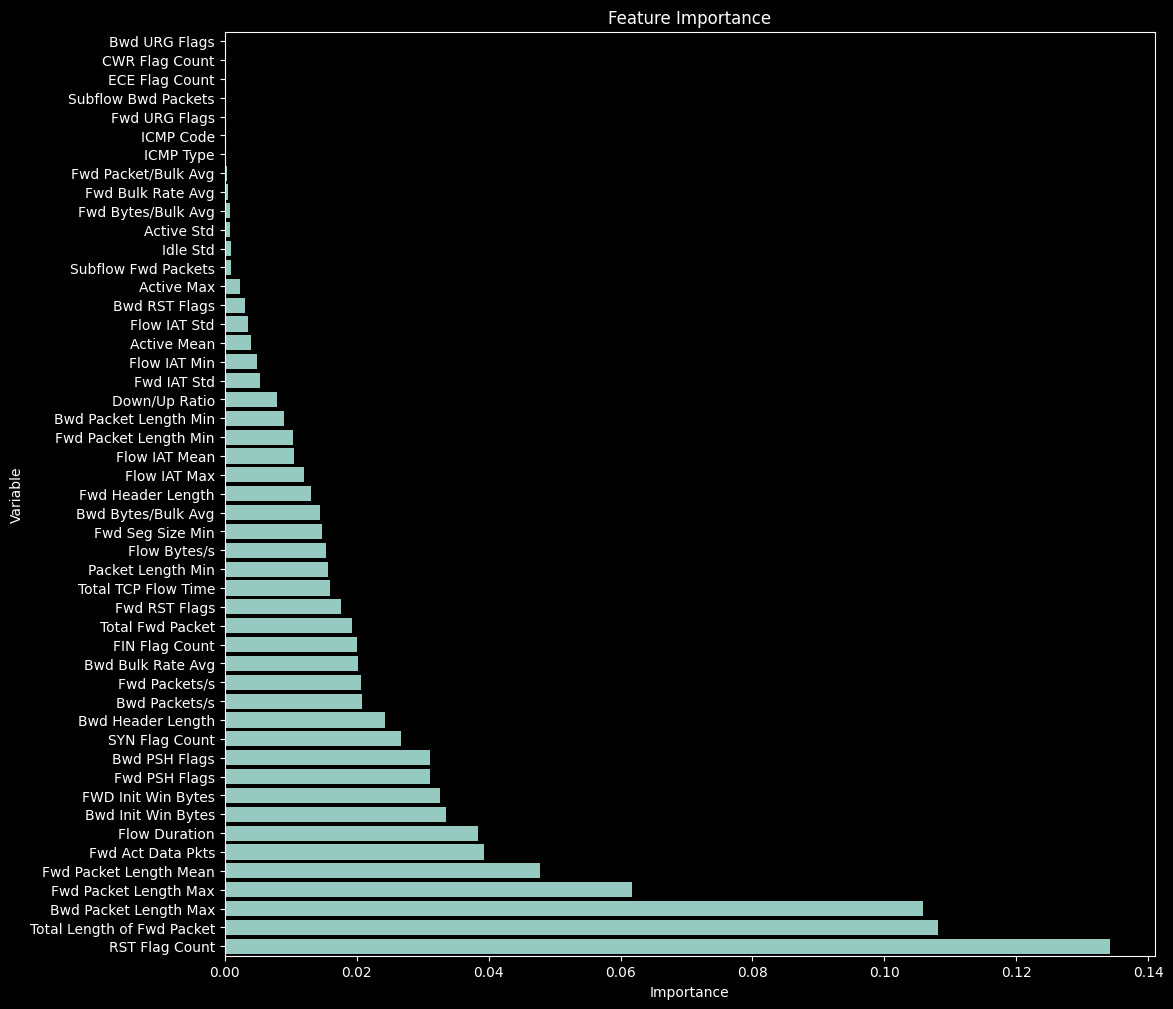

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

importances = pd.Series(
    rf.feature_importances_,
    index=x_train.columns
).sort_values(ascending=True)

plt.figure(figsize=(12, 12))
sns.barplot(x=importances.values, y=importances.index)
plt.title("Feature Importance")
plt.xlabel("Importance")
plt.ylabel("Variable")
plt.show()

## **Reducción del set de variables**

Basándose en el análisis de correlación y de feature importance, se evalúa un conjunto reducido de variables para analizar su impacto en el rendimiento del modelo y en la eficiencia computacional. Este paso explora el compromiso entre la complejidad del modelo y su capacidad de detección, un aspecto especialmente relevante en escenarios de despliegue en tiempo real.

In [ ]:
top_features = importances.tail(20).index

x_reduced = x[top_features]
x_reduced.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 440995 entries, 0 to 440994
Data columns (total 20 columns):
 #   Column                      Non-Null Count   Dtype  
---  ------                      --------------   -----  
 0   Total TCP Flow Time         440995 non-null  int64  
 1   Fwd RST Flags               440995 non-null  int64  
 2   Total Fwd Packet            440995 non-null  int64  
 3   FIN Flag Count              440995 non-null  int64  
 4   Bwd Bulk Rate Avg           440995 non-null  int64  
 5   Fwd Packets/s               440995 non-null  float64
 6   Bwd Packets/s               440995 non-null  float64
 7   Bwd Header Length           440995 non-null  int64  
 8   SYN Flag Count              440995 non-null  int64  
 9   Bwd PSH Flags               440995 non-null  int64  
 10  Fwd PSH Flags               440995 non-null  int64  
 11  FWD Init Win Bytes          440995 non-null  int64  
 12  Bwd Init Win Bytes          440995 non-null  int64  
 13  Flow Duration 

| **Variable**                  | **Descripción**                                                                                               |
| ---------------------------- | ------------------------------------------------------------------------------------------------------------- |
| `FIN Flag Count`             | Número de flags TCP FIN observados en el flujo, indicando intentos de finalización de la conexión.            |
| `Total Fwd Packet`           | Número total de paquetes enviados en la dirección forward (origen → destino).                                 |
| `Packet Length Min`          | Longitud mínima de los paquetes observados dentro del flujo.                                                  |
| `Fwd Packets/s`              | Tasa de paquetes por segundo enviados en la dirección forward.                                                |
| `Bwd Bulk Rate Avg`          | Tasa media de transferencia en bloques en la dirección backward, asociada a envíos de datos grandes o bursty. |
| `Flow Bytes/s`               | Throughput total del flujo, medido como bytes transferidos por segundo.                                       |
| `Bwd Packets/s`              | Tasa de paquetes por segundo enviados en la dirección backward.                                               |
| `Fwd PSH Flags`              | Número de flags TCP PSH activados en paquetes forward, solicitando entrega inmediata de datos.                |
| `FWD Init Win Bytes`         | Tamaño inicial de la ventana TCP anunciada en la dirección forward.                                           |
| `Fwd RST Flags`              | Número de flags TCP RST activados en paquetes forward, indicando reinicios de conexión.                       |
| `Bwd Init Win Bytes`         | Tamaño inicial de la ventana TCP anunciada en la dirección backward.                                          |
| `SYN Flag Count`             | Número de flags TCP SYN observados en el flujo, asociados al establecimiento de la conexión.                  |
| `Bwd PSH Flags`              | Número de flags TCP PSH activados en paquetes backward.                                                       |
| `Fwd Act Data Pkts`          | Número de paquetes forward que contienen carga útil de aplicación.                                            |
| `Fwd Packet Length Mean`     | Longitud media de los paquetes enviados en la dirección forward.                                              |
| `Flow Duration`              | Duración total del flujo de red.                                                                              |
| `Fwd Packet Length Max`      | Longitud máxima de los paquetes forward observados en el flujo.                                               |
| `Total Length of Fwd Packet` | Número total de bytes enviados en la dirección forward.                                                       |
| `RST Flag Count`             | Número total de flags TCP RST observados en el flujo.                                                         |
| `Bwd Packet Length Max`      | Longitud máxima de los paquetes enviados en la dirección backward.                                            |


In [ ]:
x_train, x_test, y_train, y_test = train_test_split(x_reduced, y, test_size=0.3, random_state=42, stratify=y)

x_train.shape

(308696, 20)

In [ ]:
rf_reduced = RandomForestClassifier(n_estimators=100, random_state=42, verbose=1)
rf_reduced.fit(x_train, y_train)

[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:   31.8s
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:  1.1min finished


RandomForestClassifier(random_state=42, verbose=1)

In [ ]:
rf_reduced.get_params()

{'bootstrap': True,
 'ccp_alpha': 0.0,
 'class_weight': None,
 'criterion': 'gini',
 'max_depth': None,
 'max_features': 'sqrt',
 'max_leaf_nodes': None,
 'max_samples': None,
 'min_impurity_decrease': 0.0,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'min_weight_fraction_leaf': 0.0,
 'monotonic_cst': None,
 'n_estimators': 100,
 'n_jobs': None,
 'oob_score': False,
 'random_state': 42,
 'verbose': 1,
 'warm_start': False}

In [ ]:
y_pred = rf_reduced.predict(x_test)

print('Accuracy:', accuracy_score(y_test, y_pred))
print('\nConfusion Matrix:\n')
print(confusion_matrix(y_test, y_pred))
print('\nClassification Report:\n')
print(classification_report(y_test,y_pred))

[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    0.4s


Accuracy: 0.9990249359405589

Confusion Matrix:

[[32534    63]
 [   66 99636]]

Classification Report:

              precision    recall  f1-score   support

           0       1.00      1.00      1.00     32597
           1       1.00      1.00      1.00     99702

    accuracy                           1.00    132299
   macro avg       1.00      1.00      1.00    132299
weighted avg       1.00      1.00      1.00    132299



[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.8s finished


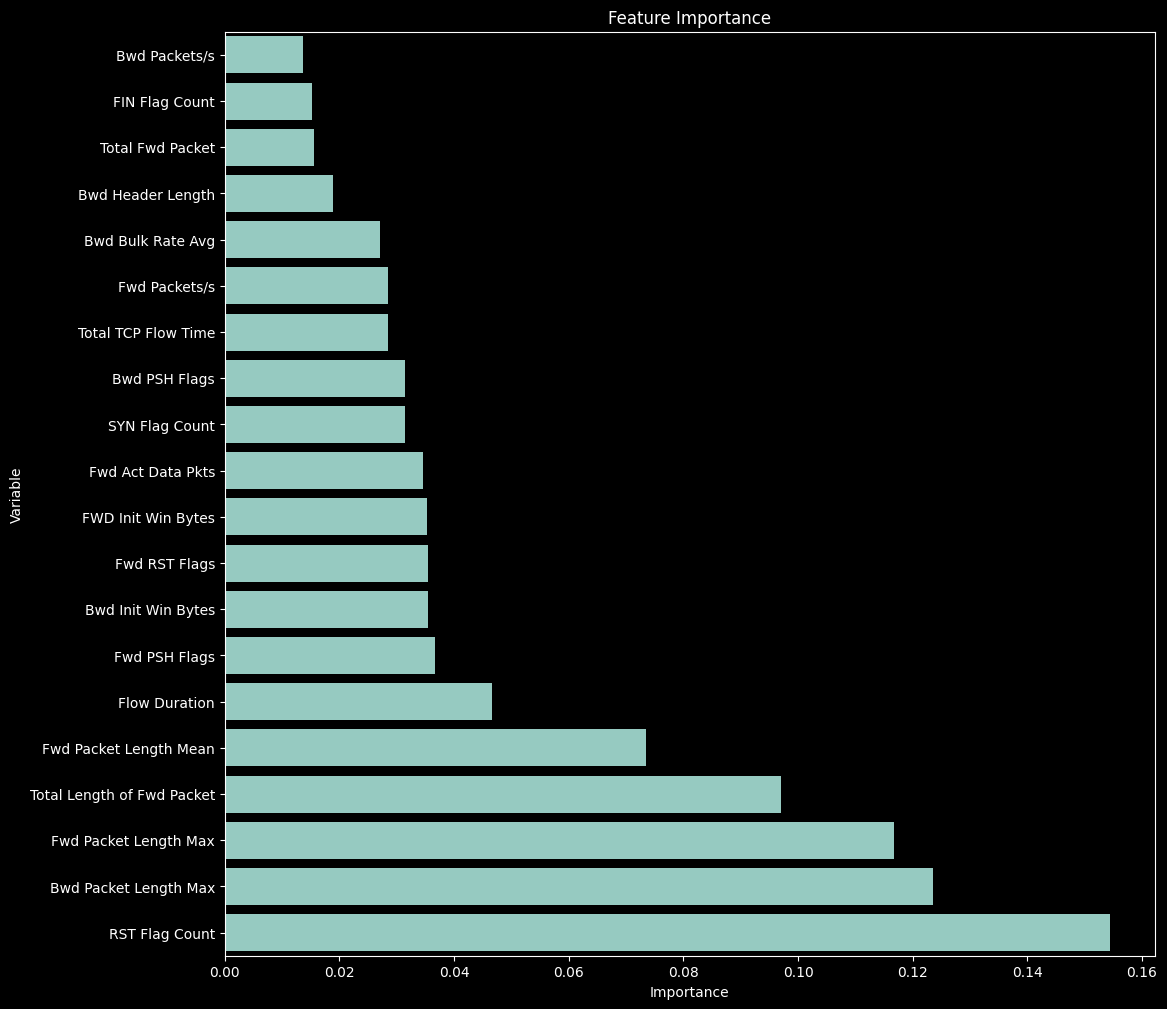

In [ ]:
importances_reduced = pd.Series(
    rf_reduced.feature_importances_,
    index=x_train.columns
).sort_values(ascending=True)

plt.figure(figsize=(12, 12))
sns.barplot(x=importances_reduced.values, y=importances_reduced.index)
plt.title("Feature Importance")
plt.xlabel("Importance")
plt.ylabel("Variable")
plt.show()

## **Predicciones**

Tanto las predicciones de clase (predict) como las probabilidades de clase (predict_proba) se utilizan para interpretar las salidas del modelo. Mientras que predict proporciona la decisión final de clasificación, predict_proba permite la toma de decisiones basada en umbrales. En los sistemas de detección de intrusiones, las probabilidades son especialmente útiles para ajustar la sensibilidad del sistema según prioridades operativas, como minimizar falsos negativos o controlar el volumen de alertas.

In [ ]:
muestra = x_test.iloc[[0]]
muestra2 = x_test.iloc[[2]]
muestra20 = x_test.iloc[[20]]
print('Sample characteristic:\n')
display(muestra)
display(muestra2)
display(muestra20)

Sample characteristic:



,Total TCP Flow Time,Fwd RST Flags,Total Fwd Packet,FIN Flag Count,Bwd Bulk Rate Avg,Fwd Packets/s,Bwd Packets/s,Bwd Header Length,SYN Flag Count,Bwd PSH Flags,Fwd PSH Flags,FWD Init Win Bytes,Bwd Init Win Bytes,Flow Duration,Fwd Act Data Pkts,Fwd Packet Length Mean,Fwd Packet Length Max,Bwd Packet Length Max,Total Length of Fwd Packet,RST Flag Count
252816,0,0,1,0,0,42.329834,42.329834,8,0,0,0,0,0,23624,0,33.0,33,102,33,0


,Total TCP Flow Time,Fwd RST Flags,Total Fwd Packet,FIN Flag Count,Bwd Bulk Rate Avg,Fwd Packets/s,Bwd Packets/s,Bwd Header Length,SYN Flag Count,Bwd PSH Flags,Fwd PSH Flags,FWD Init Win Bytes,Bwd Init Win Bytes,Flow Duration,Fwd Act Data Pkts,Fwd Packet Length Mean,Fwd Packet Length Max,Bwd Packet Length Max,Total Length of Fwd Packet,RST Flag Count
113981,34,0,1,0,0,29411.764706,29411.764706,20,1,0,0,1024,0,34,0,0.0,0,0,0,1


,Total TCP Flow Time,Fwd RST Flags,Total Fwd Packet,FIN Flag Count,Bwd Bulk Rate Avg,Fwd Packets/s,Bwd Packets/s,Bwd Header Length,SYN Flag Count,Bwd PSH Flags,Fwd PSH Flags,FWD Init Win Bytes,Bwd Init Win Bytes,Flow Duration,Fwd Act Data Pkts,Fwd Packet Length Mean,Fwd Packet Length Max,Bwd Packet Length Max,Total Length of Fwd Packet,RST Flag Count
85419,0,0,2,0,0,14925.373134,14925.373134,16,0,0,0,0,0,134,1,33.0,33,117,66,0


In [ ]:
pred = rf_reduced.predict(muestra)
proba = rf_reduced.predict_proba(muestra)
pred2 = rf_reduced.predict(muestra2)
proba2 = rf_reduced.predict_proba(muestra2)
pred20 = rf_reduced.predict(muestra20)
proba20 = rf_reduced.predict_proba(muestra20)

[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished


In [ ]:
print(f'\nPrediction sample 0:', (pred)[0])
print(f"BENIGN: {proba[0][0]:.4f}")
print(f"ATTACK: {proba[0][1]:.4f}")
print(f'\nPrediction sample 2:', (pred2)[0])
print(f"BENIGN: {proba2[0][0]:.4f}")
print(f"ATTACK: {proba2[0][1]:.4f}")
print(f'\nPrediction sample 20:', (pred20)[0])
print(f"BENIGN: {proba20[0][0]:.4f}")
print(f"ATTACK: {proba20[0][1]:.4f}")


Prediction sample 0: 1
BENIGN: 0.0000
ATTACK: 1.0000

Prediction sample 2: 0
BENIGN: 1.0000
ATTACK: 0.0000

Prediction sample 20: 1
BENIGN: 0.0000
ATTACK: 1.0000


In [ ]:
import joblib

joblib.dump(rf_reduced, 'modelo_rf.pkl')

['modelo_rf.pkl']

#**Conclusiones**
##**Resultados principales**

- Se desarrolló un pipeline de clasificación binaria reproducible para distinguir tráfico malicioso (Attack) de flujos de red benignos.

- El modelo se evaluó utilizando métricas adecuadas para problemas de clasificación desbalanceada, incluyendo Precision–Recall AUC, con especial atención a la capacidad de detección y al comportamiento frente a falsos positivos.

- Los resultados demuestran que los modelos de machine learning basados en árboles, como Random Forest, pueden modelar patrones complejos de tráfico de red en datasets de referencia controlados como CICIDS2017.

##**Vías de desarrollo futuras**

- Uso de validación cruzada para evaluar la estabilidad del modelo y reducir la posible varianza introducida por una única partición train–test.

- Evaluación por tipo de ataque para analizar el rendimiento de detección en distintas categorías de intrusión e identificar debilidades específicas.

- Exploración de la optimización del umbral de decisión para equilibrar mejor la sensibilidad de detección y el volumen de alertas en despliegues orientados a SIEM.

- Validación sobre tráfico real o desplazado temporalmente para evaluar la capacidad de generalización más allá del dataset de referencia.